# Locating lung mask's center

In this notebook we will describe the steps needed to locate the center of a lung mask.

You will need a slice from both a CT image and its corresponding masks. Use the notebook **get_slice**, located in this same folder, to get the slice you need.

First of all, import the required libraries:

In [109]:
from pathlib import Path
import numpy as np
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt

These variables store the path of the slices (image and masks) we are going to work with:

In [110]:
slice_number = 98
data_folder_path = Path('data')
image_slice_path = data_folder_path / Path(f'coronacases_001_image_slice_{slice_number}.npy')
masks_slice_path = data_folder_path /Path(f'coronacases_001_masks_slice_{slice_number}.npy')

Let's load the image slice:

In [111]:
image_slice = np.load(image_slice_path)
image_slice.shape

(512, 512)

Now, let's load the masks slice:

In [112]:
masks_slice = np.load(masks_slice_path)
masks_slice.shape

(512, 512)

Let's calculate the center of mass of each mask. The number of masks is not fixed, and it could be that no masks were saved to the file, because the organ being segmented was not present in the image:

In [113]:
masks_indexes = np.unique(masks_slice)
print(f'Masks values: {masks_indexes}')

masks_centers_of_mass = []
if len(masks_indexes) > 1:
    for mask_index in np.arange(start=1, stop=masks_indexes.max() + 1):
        mask = masks_slice == mask_index
        mask_center_of_mass = center_of_mass(mask)
        masks_centers_of_mass.append(mask_center_of_mass)

masks_centers_of_mass = np.array(masks_centers_of_mass).astype(np.uint)
print(f'Masks centers of mass: {masks_centers_of_mass}')

Masks values: [0 1 2]
Masks centers of mass: [[339 292]
 [167 298]]


Now, let's show those centers of mass. To make sure everything makes sense, only the mask marked with ones and its center of mass will be shown.

In order to display the slice, its masks, and their centers of mass ina way that makes sense to me, the data passed to `imshow()` must be rotated 270º and then flipped left to right. **I still don't understand this**.

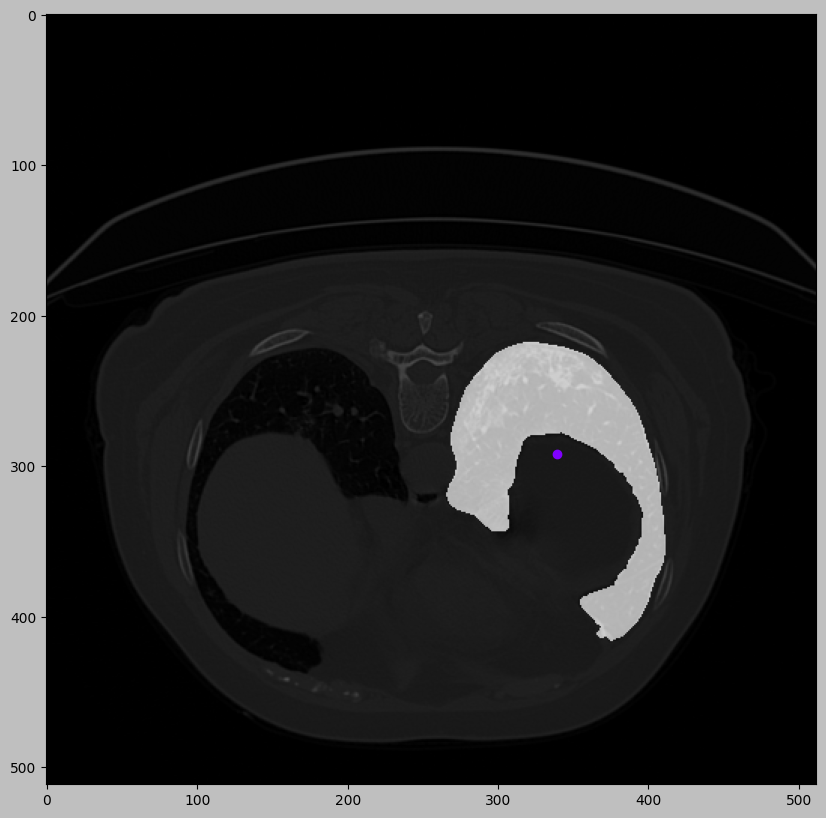

In [117]:
mask_index = 0
mask = masks_slice == mask_index + 1
mask_center_of_mass = masks_centers_of_mass[mask_index]

plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(np.fliplr(np.rot90(image_slice, k=3)))
plt.imshow(np.fliplr(np.rot90(mask, k=3)), alpha=0.7)
colors = plt.colormaps['rainbow'](np.linspace(0, 1, len(masks_centers_of_mass) + 1))
plt.scatter(mask_center_of_mass[0], mask_center_of_mass[1], color=colors[0])
plt.show()

Slice 98 is a very particular one. First lung's center of mass (not the one shown above) is outside the lung, and surrounded by it at every direction.

We are going to use the other one's center of mass as a seed. Now, let's look at the number of mask points above, below, left and right of the center of mass:

In [149]:
print(f'mask: {mask.shape}')

mask_center_of_mass = masks_centers_of_mass[mask_index]
print(f'mask_center_of_mass: {mask_center_of_mass}')

mask_points_left = mask[:mask_center_of_mass[0], mask_center_of_mass[1]]
mask_points_right = mask[int(mask_center_of_mass[0] + 1):, mask_center_of_mass[1]]
mask_points_above = mask[mask_center_of_mass[0], :mask_center_of_mass[1]]
mask_points_below = mask[mask_center_of_mass[0], int(mask_center_of_mass[1] + 1):]

print(f'Points left: {len(mask_points_left)}')
print(f'Points right: {len(mask_points_right)}')
print(f'Points above: {len(mask_points_above)}')
print(f'Points below: {len(mask_points_below)}')

print(f'Mask points left: {np.sum(mask_points_left)}')
print(f'Mask points right: {np.sum(mask_points_right)}')
print(f'Mask points above: {np.sum(mask_points_above)}')
print(f'Mask points below: {np.sum(mask_points_below)}')


mask: (512, 512)
mask_center_of_mass: [339 292]
Points left: 339
Points right: 172
Points above: 292
Points below: 219
Mask points left: 44
Mask points right: 34
Mask points above: 59
Mask points below: 0


In this particular clase, the segment with more mask points is the one above the center of mass. Let's move the center of mass above, so it is in the middle of said segment:

In [150]:
mask_segment = np.where(mask_points_above == True)[0]
segment_y = np.arange(mask_segment[0], mask_segment[-1] + 1)
segment_x = np.repeat(mask_center_of_mass[0], len(segment_y))
print(f'segment_x: {segment_x}')
print(f'segment_y: {segment_y}')
x = mask_center_of_mass[0]
y = int(np.mean(mask_segment))

segment_x: [339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339
 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339
 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339 339
 339 339 339 339 339]
segment_y: [220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278]


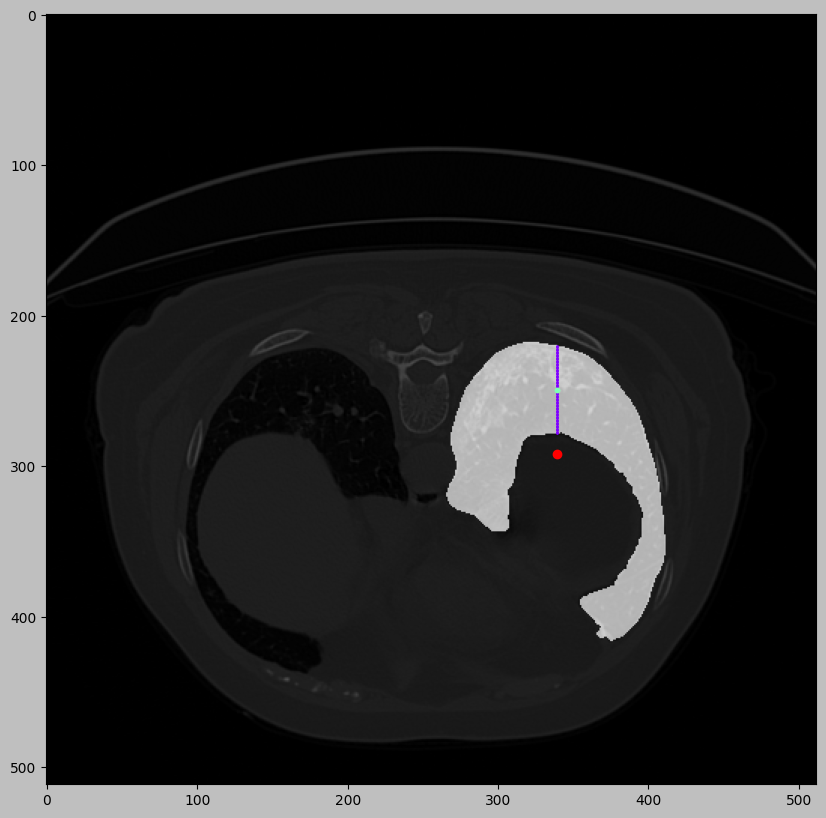

In [152]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(np.fliplr(np.rot90(image_slice, k=3)))
plt.imshow(np.fliplr(np.rot90(mask, k=3)), alpha=0.7)

colors = plt.colormaps['rainbow'](np.linspace(0, 1, len(masks_centers_of_mass) + 1))
plt.scatter(x=segment_x, y=segment_y, color=colors[0], s=1)
plt.scatter(x=x, y=y, color=colors[1], s=10)
plt.scatter(mask_center_of_mass[0], mask_center_of_mass[1], color=colors[2])

So that's it. Now the only thing left is:

1. Determine if the center of mass is inside or outside the mask.
2. Generalize the new center calculation.